<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Fri Aug  9 15:47:32 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.70                 Driver Version: 560.70         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8              1W /   50W |     376MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.4.0


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1. Regularization - penalizes models for complex or large weights, which can reduce variance and prevent overfitting
2. Data augmentation - modify existing data by adding noise or transformations, which can add the data variability
3. Train with more data - by collecting more data or enhancing the data which equips your model with richer foundation

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [33]:
# 1. Get data
from pathlib import Path 
import requests  
import zipfile

DIR_PATH = Path("data")
IMAGE_PATH = DIR_PATH / "pizza_steak_sushi.zip"

if IMAGE_PATH.is_file():
    print("the files already exist!")
else: 
    print("downloading...")
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    with open(DIR_PATH / "pizza_steak_sushi.zip", "wb") as f: 
        f.write(request.content)

the files already exist!


In [34]:
IMAGE_PATH

WindowsPath('data/pizza_steak_sushi.zip')

In [38]:
IMAGE_DATASET_PATH = DIR_PATH / "pizza_steak_sushi"

if IMAGE_DATASET_PATH.is_dir():
    print("already exists")
else: 
    print("unzipping...")
    with zipfile.ZipFile(IMAGE_PATH, "r") as zip_ref: 
        zip_ref.extractall(IMAGE_DATASET_PATH)

unzipping...


In [39]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [40]:
walk_through_dir(dir_path=IMAGE_DATASET_PATH)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [41]:
IMAGE_DATASET_PATH

WindowsPath('data/pizza_steak_sushi')

In [47]:
# Setup train and testing paths
TRAIN_PATHS = list(IMAGE_DATASET_PATH.glob("train/*/*.jpg"))
TEST_PATHS = list(IMAGE_DATASET_PATH.glob("test/*/*.jpg"))

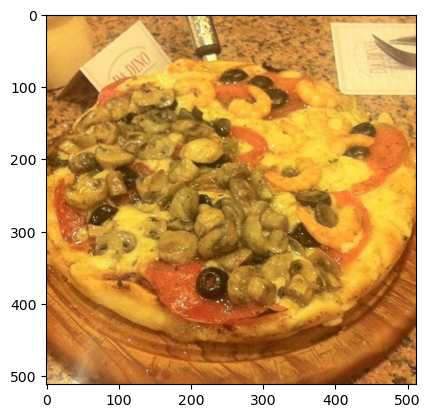

In [51]:
# Do the image visualization with matplotlib
import matplotlib.pyplot as plt 
from PIL import Image

plt.imshow(Image.open(TRAIN_PATHS[10]))

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [52]:
# 3.1 Transforming data with torchvision.transforms
from torchvision import transforms

In [53]:
# Write transform for turning images into tensors
transform_data = transforms.Compose([ 
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [87]:
# Write a function to plot transformed images
def plot_transformed(image_path, transform_func, n: int): 
    plt.figure(figsize=(10, 15))

    fig, ax = plt.subplots(1, 2)
    with Image.open(image_path) as img: 
        # plot original image 
        ax[0].imshow(img)
        ax[0].set_title(f"original: {img.size}")
            
        # plot transformed image 
        transformed_img = transform_func(img).permute(1, 2, 0)
        ax[1].imshow(transformed_img)
        ax[1].set_title(f"tranformed: {transformed_img.shape}")

        plt.suptitle(image_path.parent.stem)
            

<Figure size 1000x1500 with 0 Axes>

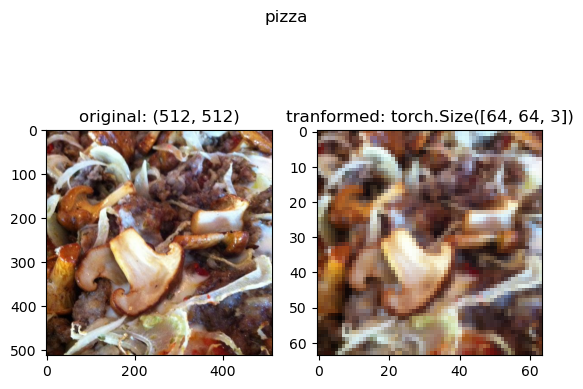

In [100]:
plot_transformed(image_path=TRAIN_PATHS[20], transform_func=transform_data, n=10)

### Load image data using `ImageFolder`

In [92]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_path = IMAGE_DATASET_PATH / "train"
test_path = IMAGE_DATASET_PATH / "test"

train_data = datasets.ImageFolder(root=train_path, transform=transform_data)
test_data = datasets.ImageFolder(root=test_path, transform=transform_data)

In [95]:
len(train_data), len(test_data)

(225, 75)

In [96]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [97]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [98]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [122]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

In [123]:
# How many batches of images are in our data loaders?
a, b = next(iter(train_dataloader))
a, b, len(train_dataloader)

(tensor([[[[0.9490, 0.8941, 0.9412,  ..., 0.0902, 0.0667, 0.0588],
           [0.8627, 0.7490, 0.8000,  ..., 0.1961, 0.1725, 0.1529],
           [0.7373, 0.6706, 0.6667,  ..., 0.0784, 0.0784, 0.0863],
           ...,
           [0.1843, 0.2000, 0.2078,  ..., 0.4392, 0.4431, 0.4314],
           [0.3176, 0.3098, 0.2706,  ..., 0.4275, 0.3647, 0.3255],
           [0.8118, 0.7961, 0.7608,  ..., 0.2745, 0.3137, 0.3765]],
 
          [[0.9608, 0.9412, 0.9608,  ..., 0.2078, 0.1804, 0.1490],
           [0.8745, 0.8549, 0.8824,  ..., 0.3569, 0.3373, 0.3176],
           [0.7608, 0.7843, 0.7882,  ..., 0.2000, 0.1922, 0.2000],
           ...,
           [0.2431, 0.2588, 0.2824,  ..., 0.4549, 0.4824, 0.4902],
           [0.4314, 0.4196, 0.3843,  ..., 0.4863, 0.4275, 0.4000],
           [0.8824, 0.8745, 0.8510,  ..., 0.3686, 0.4196, 0.4941]],
 
          [[0.7412, 0.7333, 0.7412,  ..., 0.3922, 0.3765, 0.3608],
           [0.7373, 0.7333, 0.7373,  ..., 0.4471, 0.4392, 0.4353],
           [0.7098, 0.72

In [124]:
class_name = train_data.classes
class_name

['pizza', 'steak', 'sushi']

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [125]:
# set device agnostic-code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [126]:
from torch import nn

In [161]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_units=10): 
        super().__init__()

        # 32
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2)
        )

        # 16
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2)
        )

        # 8
        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential( 
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*8*8, out_features=output_shape)
        )

    def forward(self, x):
        return self.classifier(self.conv_layer_3(self.conv_layer_2(self.conv_layer_1(x))))
    
model_0 = TinyVGG(input_shape=3, output_shape=len(class_name), hidden_units=64).to(device)
model_0

TinyVGG(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_fea

In [149]:
from torchinfo import summary

summary(model=model_0, input_size=(32, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 64, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 64, 64, 64]          1,792
│    └─ReLU: 2-2                         [32, 64, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 64, 64, 64]          36,928
│    └─ReLU: 2-4                         [32, 64, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 64, 32, 32]          --
├─Sequential: 1-2                        [32, 64, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 64, 32, 32]          36,928
│    └─ReLU: 2-7                         [32, 64, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 64, 32, 32]          36,928
│    └─ReLU: 2-9                         [32, 64, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 64, 16, 16]          --


## 4. Create training and testing functions for `model_0`.

In [185]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    logits = model(X)
    # 2. Calculate and accumulate loss
    loss = loss_fn(logits, y)
    pred = torch.softmax(logits, dim=1).argmax(dim=1)
    # 3. Optimizer zero grad 
    optimizer.zero_grad()
    # 4. Loss backward 
    loss.backward()
    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    train_loss += loss
    train_acc += (pred==y).sum().item() / len(logits)
  # Adjust metrics to get average loss and average accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

In [157]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
  
    # Loop through DataLoader batches
    for X, y in dataloader:
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_logits = model(X)

      # 2. Calculuate and accumulate loss
      test_loss += loss_fn(test_logits, y)
      pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # Calculate and accumulate accuracy
      test_acc += (pred==y).sum().item() / len(test_logits)
    
    # Adjust metrics to get average loss and accuracy per batch
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

In [158]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [162]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

model_0_adam_result = train(model=model_0, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

looked at 0/225
looked at 128/225


 20%|██        | 1/5 [00:01<00:05,  1.40s/it]

Epoch: 1 | train_loss: 1.1019 | train_acc: 0.2812 | test_loss: 1.1036 | test_acc: 0.2604
looked at 0/225
looked at 128/225


 40%|████      | 2/5 [00:02<00:03,  1.26s/it]

Epoch: 2 | train_loss: 1.0896 | train_acc: 0.4258 | test_loss: 1.1230 | test_acc: 0.2604
looked at 0/225
looked at 128/225


 60%|██████    | 3/5 [00:03<00:02,  1.23s/it]

Epoch: 3 | train_loss: 1.0931 | train_acc: 0.4258 | test_loss: 1.1213 | test_acc: 0.2604
looked at 0/225
looked at 128/225


 80%|████████  | 4/5 [00:04<00:01,  1.23s/it]

Epoch: 4 | train_loss: 1.1042 | train_acc: 0.3047 | test_loss: 1.1173 | test_acc: 0.2604
looked at 0/225
looked at 128/225


100%|██████████| 5/5 [00:06<00:00,  1.24s/it]

Epoch: 5 | train_loss: 1.0771 | train_acc: 0.4258 | test_loss: 1.1221 | test_acc: 0.2812


In [163]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.001)

model_0_adam_result_1 = train(model=model_0, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

looked at 0/225
looked at 128/225


  5%|▌         | 1/20 [00:01<00:28,  1.49s/it]

Epoch: 1 | train_loss: 1.0642 | train_acc: 0.4102 | test_loss: 1.0374 | test_acc: 0.3428
looked at 0/225
looked at 128/225


 10%|█         | 2/20 [00:02<00:23,  1.33s/it]

Epoch: 2 | train_loss: 0.9346 | train_acc: 0.5586 | test_loss: 1.0726 | test_acc: 0.3438
looked at 0/225
looked at 128/225


 15%|█▌        | 3/20 [00:03<00:21,  1.26s/it]

Epoch: 3 | train_loss: 0.9272 | train_acc: 0.6055 | test_loss: 1.0937 | test_acc: 0.4034
looked at 0/225
looked at 128/225


 20%|██        | 4/20 [00:05<00:20,  1.25s/it]

Epoch: 4 | train_loss: 0.9504 | train_acc: 0.5352 | test_loss: 1.0096 | test_acc: 0.4138
looked at 0/225
looked at 128/225


 25%|██▌       | 5/20 [00:06<00:18,  1.25s/it]

Epoch: 5 | train_loss: 0.8296 | train_acc: 0.6680 | test_loss: 1.0668 | test_acc: 0.4650
looked at 0/225
looked at 128/225


 30%|███       | 6/20 [00:07<00:17,  1.27s/it]

Epoch: 6 | train_loss: 0.9055 | train_acc: 0.5508 | test_loss: 1.0701 | test_acc: 0.4138
looked at 0/225
looked at 128/225


 35%|███▌      | 7/20 [00:09<00:16,  1.29s/it]

Epoch: 7 | train_loss: 0.7211 | train_acc: 0.7070 | test_loss: 1.0880 | test_acc: 0.4441
looked at 0/225
looked at 128/225


 40%|████      | 8/20 [00:10<00:15,  1.30s/it]

Epoch: 8 | train_loss: 0.7716 | train_acc: 0.7266 | test_loss: 1.1621 | test_acc: 0.4347
looked at 0/225
looked at 128/225


 45%|████▌     | 9/20 [00:11<00:14,  1.28s/it]

Epoch: 9 | train_loss: 0.8518 | train_acc: 0.5742 | test_loss: 1.1994 | test_acc: 0.4839
looked at 0/225
looked at 128/225


 50%|█████     | 10/20 [00:12<00:12,  1.27s/it]

Epoch: 10 | train_loss: 0.8266 | train_acc: 0.5312 | test_loss: 0.9666 | test_acc: 0.4744
looked at 0/225
looked at 128/225


 55%|█████▌    | 11/20 [00:14<00:11,  1.25s/it]

Epoch: 11 | train_loss: 0.7005 | train_acc: 0.7461 | test_loss: 1.1157 | test_acc: 0.4347
looked at 0/225
looked at 128/225


 60%|██████    | 12/20 [00:15<00:09,  1.24s/it]

Epoch: 12 | train_loss: 0.6527 | train_acc: 0.7461 | test_loss: 1.3141 | test_acc: 0.5047
looked at 0/225
looked at 128/225


 65%|██████▌   | 13/20 [00:16<00:08,  1.25s/it]

Epoch: 13 | train_loss: 0.6953 | train_acc: 0.7031 | test_loss: 1.2095 | test_acc: 0.4451
looked at 0/225
looked at 128/225


 70%|███████   | 14/20 [00:17<00:07,  1.26s/it]

Epoch: 14 | train_loss: 0.6475 | train_acc: 0.7422 | test_loss: 1.2937 | test_acc: 0.3523
looked at 0/225
looked at 128/225


 75%|███████▌  | 15/20 [00:18<00:06,  1.24s/it]

Epoch: 15 | train_loss: 0.9952 | train_acc: 0.6133 | test_loss: 1.2623 | test_acc: 0.4555
looked at 0/225
looked at 128/225


 80%|████████  | 16/20 [00:20<00:05,  1.25s/it]

Epoch: 16 | train_loss: 0.7321 | train_acc: 0.7148 | test_loss: 0.9521 | test_acc: 0.5483
looked at 0/225
looked at 128/225


 85%|████████▌ | 17/20 [00:21<00:03,  1.24s/it]

Epoch: 17 | train_loss: 0.7899 | train_acc: 0.6992 | test_loss: 1.0843 | test_acc: 0.4555
looked at 0/225
looked at 128/225


 90%|█████████ | 18/20 [00:22<00:02,  1.23s/it]

Epoch: 18 | train_loss: 0.6584 | train_acc: 0.7383 | test_loss: 1.0648 | test_acc: 0.5256
looked at 0/225
looked at 128/225


 95%|█████████▌| 19/20 [00:23<00:01,  1.23s/it]

Epoch: 19 | train_loss: 0.5779 | train_acc: 0.8125 | test_loss: 1.0924 | test_acc: 0.5369
looked at 0/225
looked at 128/225


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]

Epoch: 20 | train_loss: 0.4946 | train_acc: 0.8086 | test_loss: 1.2327 | test_acc: 0.4744


In [164]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.001)

model_0_adam_result_2 = train(model=model_0, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=50)


  0%|          | 0/50 [00:00<?, ?it/s]

looked at 0/225
looked at 128/225


  2%|▏         | 1/50 [00:01<01:05,  1.33s/it]

Epoch: 1 | train_loss: 0.5163 | train_acc: 0.7969 | test_loss: 1.1441 | test_acc: 0.4867
looked at 0/225
looked at 128/225


  4%|▍         | 2/50 [00:02<00:55,  1.17s/it]

Epoch: 2 | train_loss: 0.6166 | train_acc: 0.7109 | test_loss: 1.2745 | test_acc: 0.5473
looked at 0/225
looked at 128/225


  6%|▌         | 3/50 [00:03<00:53,  1.14s/it]

Epoch: 3 | train_loss: 0.5267 | train_acc: 0.7852 | test_loss: 1.5896 | test_acc: 0.3627
looked at 0/225
looked at 128/225


  8%|▊         | 4/50 [00:04<00:52,  1.14s/it]

Epoch: 4 | train_loss: 0.5245 | train_acc: 0.7305 | test_loss: 1.6690 | test_acc: 0.4451
looked at 0/225
looked at 128/225


 10%|█         | 5/50 [00:05<00:51,  1.15s/it]

Epoch: 5 | train_loss: 0.3599 | train_acc: 0.8594 | test_loss: 1.3947 | test_acc: 0.4536
looked at 0/225
looked at 128/225


 12%|█▏        | 6/50 [00:07<00:52,  1.19s/it]

Epoch: 6 | train_loss: 0.4087 | train_acc: 0.8438 | test_loss: 1.4226 | test_acc: 0.4953
looked at 0/225
looked at 128/225


 14%|█▍        | 7/50 [00:08<00:51,  1.19s/it]

Epoch: 7 | train_loss: 0.2456 | train_acc: 0.9219 | test_loss: 1.3702 | test_acc: 0.5758
looked at 0/225
looked at 128/225


 16%|█▌        | 8/50 [00:09<00:49,  1.19s/it]

Epoch: 8 | train_loss: 0.2558 | train_acc: 0.9180 | test_loss: 1.8454 | test_acc: 0.5256
looked at 0/225
looked at 128/225


 18%|█▊        | 9/50 [00:10<00:48,  1.19s/it]

Epoch: 9 | train_loss: 0.2390 | train_acc: 0.8945 | test_loss: 1.9259 | test_acc: 0.5549
looked at 0/225
looked at 128/225


 20%|██        | 10/50 [00:12<00:49,  1.25s/it]

Epoch: 10 | train_loss: 0.2019 | train_acc: 0.9180 | test_loss: 1.8733 | test_acc: 0.5057
looked at 0/225
looked at 128/225


 22%|██▏       | 11/50 [00:13<00:48,  1.26s/it]

Epoch: 11 | train_loss: 0.1409 | train_acc: 0.9531 | test_loss: 1.7242 | test_acc: 0.5852
looked at 0/225
looked at 128/225


 24%|██▍       | 12/50 [00:14<00:47,  1.24s/it]

Epoch: 12 | train_loss: 0.0954 | train_acc: 0.9727 | test_loss: 2.1689 | test_acc: 0.5455
looked at 0/225
looked at 128/225


 26%|██▌       | 13/50 [00:15<00:45,  1.22s/it]

Epoch: 13 | train_loss: 0.0869 | train_acc: 0.9844 | test_loss: 2.5612 | test_acc: 0.5464
looked at 0/225
looked at 128/225


 28%|██▊       | 14/50 [00:16<00:43,  1.22s/it]

Epoch: 14 | train_loss: 0.1079 | train_acc: 0.9648 | test_loss: 2.6391 | test_acc: 0.4830
looked at 0/225
looked at 128/225


 30%|███       | 15/50 [00:18<00:42,  1.23s/it]

Epoch: 15 | train_loss: 0.1670 | train_acc: 0.9375 | test_loss: 2.7397 | test_acc: 0.5152
looked at 0/225
looked at 128/225


 32%|███▏      | 16/50 [00:19<00:41,  1.23s/it]

Epoch: 16 | train_loss: 0.0597 | train_acc: 0.9766 | test_loss: 2.6947 | test_acc: 0.5455
looked at 0/225
looked at 128/225


 34%|███▍      | 17/50 [00:20<00:40,  1.24s/it]

Epoch: 17 | train_loss: 0.0695 | train_acc: 0.9922 | test_loss: 3.2707 | test_acc: 0.5559
looked at 0/225
looked at 128/225


 36%|███▌      | 18/50 [00:21<00:38,  1.22s/it]

Epoch: 18 | train_loss: 0.2905 | train_acc: 0.9219 | test_loss: 3.3354 | test_acc: 0.4744
looked at 0/225
looked at 128/225


 38%|███▊      | 19/50 [00:23<00:38,  1.24s/it]

Epoch: 19 | train_loss: 0.1639 | train_acc: 0.9492 | test_loss: 2.8146 | test_acc: 0.4640
looked at 0/225
looked at 128/225


 40%|████      | 20/50 [00:24<00:36,  1.23s/it]

Epoch: 20 | train_loss: 0.2890 | train_acc: 0.8359 | test_loss: 2.6073 | test_acc: 0.5142
looked at 0/225
looked at 128/225


 42%|████▏     | 21/50 [00:25<00:35,  1.21s/it]

Epoch: 21 | train_loss: 0.3576 | train_acc: 0.8867 | test_loss: 2.3666 | test_acc: 0.4953
looked at 0/225
looked at 128/225


 44%|████▍     | 22/50 [00:26<00:33,  1.19s/it]

Epoch: 22 | train_loss: 0.2088 | train_acc: 0.9336 | test_loss: 1.8300 | test_acc: 0.4934
looked at 0/225
looked at 128/225


 46%|████▌     | 23/50 [00:27<00:31,  1.18s/it]

Epoch: 23 | train_loss: 0.1764 | train_acc: 0.9414 | test_loss: 2.1044 | test_acc: 0.5350
looked at 0/225
looked at 128/225


 48%|████▊     | 24/50 [00:28<00:30,  1.18s/it]

Epoch: 24 | train_loss: 0.0704 | train_acc: 0.9766 | test_loss: 2.1906 | test_acc: 0.5350
looked at 0/225
looked at 128/225


 50%|█████     | 25/50 [00:30<00:29,  1.17s/it]

Epoch: 25 | train_loss: 0.0536 | train_acc: 0.9883 | test_loss: 2.4471 | test_acc: 0.5256
looked at 0/225
looked at 128/225


 52%|█████▏    | 26/50 [00:31<00:28,  1.17s/it]

Epoch: 26 | train_loss: 0.0441 | train_acc: 0.9922 | test_loss: 2.6509 | test_acc: 0.5152
looked at 0/225
looked at 128/225


 54%|█████▍    | 27/50 [00:32<00:27,  1.18s/it]

Epoch: 27 | train_loss: 0.0303 | train_acc: 0.9922 | test_loss: 3.2758 | test_acc: 0.5256
looked at 0/225
looked at 128/225


 56%|█████▌    | 28/50 [00:33<00:25,  1.18s/it]

Epoch: 28 | train_loss: 0.0200 | train_acc: 0.9961 | test_loss: 3.6933 | test_acc: 0.5350
looked at 0/225
looked at 128/225


 58%|█████▊    | 29/50 [00:34<00:24,  1.17s/it]

Epoch: 29 | train_loss: 0.0061 | train_acc: 1.0000 | test_loss: 3.9105 | test_acc: 0.5350
looked at 0/225
looked at 128/225


 60%|██████    | 30/50 [00:35<00:23,  1.17s/it]

Epoch: 30 | train_loss: 0.0050 | train_acc: 1.0000 | test_loss: 4.1177 | test_acc: 0.5350
looked at 0/225
looked at 128/225


 62%|██████▏   | 31/50 [00:37<00:22,  1.17s/it]

Epoch: 31 | train_loss: 0.0042 | train_acc: 1.0000 | test_loss: 4.1472 | test_acc: 0.5350
looked at 0/225
looked at 128/225


 64%|██████▍   | 32/50 [00:38<00:21,  1.17s/it]

Epoch: 32 | train_loss: 0.0016 | train_acc: 1.0000 | test_loss: 4.4426 | test_acc: 0.5350
looked at 0/225
looked at 128/225


 66%|██████▌   | 33/50 [00:39<00:19,  1.17s/it]

Epoch: 33 | train_loss: 0.0010 | train_acc: 1.0000 | test_loss: 4.6423 | test_acc: 0.5350
looked at 0/225
looked at 128/225


 68%|██████▊   | 34/50 [00:40<00:18,  1.17s/it]

Epoch: 34 | train_loss: 0.0009 | train_acc: 1.0000 | test_loss: 4.6785 | test_acc: 0.5350
looked at 0/225
looked at 128/225


 70%|███████   | 35/50 [00:41<00:17,  1.17s/it]

Epoch: 35 | train_loss: 0.0016 | train_acc: 1.0000 | test_loss: 4.7216 | test_acc: 0.5350
looked at 0/225
looked at 128/225


 72%|███████▏  | 36/50 [00:42<00:16,  1.17s/it]

Epoch: 36 | train_loss: 0.0011 | train_acc: 1.0000 | test_loss: 4.7028 | test_acc: 0.5350
looked at 0/225
looked at 128/225


 74%|███████▍  | 37/50 [00:44<00:15,  1.18s/it]

Epoch: 37 | train_loss: 0.0010 | train_acc: 1.0000 | test_loss: 4.6692 | test_acc: 0.5350
looked at 0/225
looked at 128/225


 76%|███████▌  | 38/50 [00:45<00:14,  1.20s/it]

Epoch: 38 | train_loss: 0.0011 | train_acc: 1.0000 | test_loss: 4.8197 | test_acc: 0.5350
looked at 0/225
looked at 128/225


 78%|███████▊  | 39/50 [00:46<00:13,  1.19s/it]

Epoch: 39 | train_loss: 0.0005 | train_acc: 1.0000 | test_loss: 5.0904 | test_acc: 0.5455
looked at 0/225
looked at 128/225


 80%|████████  | 40/50 [00:47<00:11,  1.18s/it]

Epoch: 40 | train_loss: 0.0004 | train_acc: 1.0000 | test_loss: 5.2273 | test_acc: 0.5455
looked at 0/225
looked at 128/225


 82%|████████▏ | 41/50 [00:48<00:10,  1.18s/it]

Epoch: 41 | train_loss: 0.0004 | train_acc: 1.0000 | test_loss: 5.2447 | test_acc: 0.5455
looked at 0/225
looked at 128/225


 84%|████████▍ | 42/50 [00:50<00:09,  1.18s/it]

Epoch: 42 | train_loss: 0.0005 | train_acc: 1.0000 | test_loss: 5.2483 | test_acc: 0.5350
looked at 0/225
looked at 128/225


 86%|████████▌ | 43/50 [00:51<00:08,  1.18s/it]

Epoch: 43 | train_loss: 0.0003 | train_acc: 1.0000 | test_loss: 5.2779 | test_acc: 0.5350
looked at 0/225
looked at 128/225


 88%|████████▊ | 44/50 [00:52<00:07,  1.18s/it]

Epoch: 44 | train_loss: 0.0002 | train_acc: 1.0000 | test_loss: 5.3018 | test_acc: 0.5350
looked at 0/225
looked at 128/225


 90%|█████████ | 45/50 [00:53<00:05,  1.19s/it]

Epoch: 45 | train_loss: 0.0002 | train_acc: 1.0000 | test_loss: 5.3257 | test_acc: 0.5350
looked at 0/225
looked at 128/225


 92%|█████████▏| 46/50 [00:54<00:04,  1.20s/it]

Epoch: 46 | train_loss: 0.0002 | train_acc: 1.0000 | test_loss: 5.3545 | test_acc: 0.5350
looked at 0/225
looked at 128/225


 94%|█████████▍| 47/50 [00:56<00:03,  1.20s/it]

Epoch: 47 | train_loss: 0.0002 | train_acc: 1.0000 | test_loss: 5.3770 | test_acc: 0.5350
looked at 0/225
looked at 128/225


 96%|█████████▌| 48/50 [00:57<00:02,  1.19s/it]

Epoch: 48 | train_loss: 0.0002 | train_acc: 1.0000 | test_loss: 5.4052 | test_acc: 0.5350
looked at 0/225
looked at 128/225


 98%|█████████▊| 49/50 [00:58<00:01,  1.18s/it]

Epoch: 49 | train_loss: 0.0002 | train_acc: 1.0000 | test_loss: 5.4468 | test_acc: 0.5350
looked at 0/225
looked at 128/225


100%|██████████| 50/50 [00:59<00:00,  1.19s/it]

Epoch: 50 | train_loss: 0.0002 | train_acc: 1.0000 | test_loss: 5.4848 | test_acc: 0.5350


It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [168]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG(input_shape=3, output_shape=len(class_names), hidden_units=128).to(device)
model_1

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.001)

model_1_adam_result = train(model=model_1, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

looked at 0/225
looked at 128/225


  5%|▌         | 1/20 [00:01<00:32,  1.73s/it]

Epoch: 1 | train_loss: 1.0978 | train_acc: 0.4023 | test_loss: 1.0957 | test_acc: 0.5417
looked at 0/225
looked at 128/225


 10%|█         | 2/20 [00:03<00:27,  1.51s/it]

Epoch: 2 | train_loss: 1.1000 | train_acc: 0.2812 | test_loss: 1.0957 | test_acc: 0.5417
looked at 0/225
looked at 128/225


 15%|█▌        | 3/20 [00:04<00:24,  1.42s/it]

Epoch: 3 | train_loss: 1.0986 | train_acc: 0.2812 | test_loss: 1.0957 | test_acc: 0.5417
looked at 0/225
looked at 128/225


 20%|██        | 4/20 [00:05<00:22,  1.38s/it]

Epoch: 4 | train_loss: 1.0978 | train_acc: 0.4023 | test_loss: 1.0957 | test_acc: 0.5417
looked at 0/225
looked at 128/225


 25%|██▌       | 5/20 [00:07<00:20,  1.35s/it]

Epoch: 5 | train_loss: 1.0979 | train_acc: 0.4023 | test_loss: 1.0957 | test_acc: 0.5417
looked at 0/225
looked at 128/225


 30%|███       | 6/20 [00:08<00:18,  1.34s/it]

Epoch: 6 | train_loss: 1.0978 | train_acc: 0.4023 | test_loss: 1.0957 | test_acc: 0.5417
looked at 0/225
looked at 128/225


 35%|███▌      | 7/20 [00:09<00:17,  1.33s/it]

Epoch: 7 | train_loss: 1.0978 | train_acc: 0.4023 | test_loss: 1.0957 | test_acc: 0.5417
looked at 0/225
looked at 128/225


 40%|████      | 8/20 [00:10<00:15,  1.32s/it]

Epoch: 8 | train_loss: 1.0986 | train_acc: 0.2812 | test_loss: 1.0957 | test_acc: 0.5417
looked at 0/225
looked at 128/225


 45%|████▌     | 9/20 [00:12<00:14,  1.34s/it]

Epoch: 9 | train_loss: 1.0979 | train_acc: 0.4023 | test_loss: 1.0957 | test_acc: 0.5417
looked at 0/225
looked at 128/225


 50%|█████     | 10/20 [00:13<00:13,  1.34s/it]

Epoch: 10 | train_loss: 1.0988 | train_acc: 0.2812 | test_loss: 1.0957 | test_acc: 0.5417
looked at 0/225
looked at 128/225


 55%|█████▌    | 11/20 [00:14<00:12,  1.33s/it]

Epoch: 11 | train_loss: 1.1000 | train_acc: 0.2812 | test_loss: 1.0957 | test_acc: 0.5417
looked at 0/225
looked at 128/225


 60%|██████    | 12/20 [00:16<00:10,  1.33s/it]

Epoch: 12 | train_loss: 1.0987 | train_acc: 0.2812 | test_loss: 1.0957 | test_acc: 0.5417
looked at 0/225
looked at 128/225


 65%|██████▌   | 13/20 [00:17<00:09,  1.34s/it]

Epoch: 13 | train_loss: 1.0986 | train_acc: 0.2812 | test_loss: 1.0957 | test_acc: 0.5417
looked at 0/225
looked at 128/225


 70%|███████   | 14/20 [00:19<00:08,  1.34s/it]

Epoch: 14 | train_loss: 1.0986 | train_acc: 0.2812 | test_loss: 1.0957 | test_acc: 0.5417
looked at 0/225
looked at 128/225


 75%|███████▌  | 15/20 [00:20<00:06,  1.37s/it]

Epoch: 15 | train_loss: 1.0978 | train_acc: 0.4023 | test_loss: 1.0957 | test_acc: 0.5417
looked at 0/225
looked at 128/225


 80%|████████  | 16/20 [00:21<00:05,  1.36s/it]

Epoch: 16 | train_loss: 1.0987 | train_acc: 0.2812 | test_loss: 1.0957 | test_acc: 0.5417
looked at 0/225
looked at 128/225


 85%|████████▌ | 17/20 [00:23<00:04,  1.36s/it]

Epoch: 17 | train_loss: 1.0987 | train_acc: 0.2812 | test_loss: 1.0957 | test_acc: 0.5417
looked at 0/225
looked at 128/225


 90%|█████████ | 18/20 [00:24<00:02,  1.36s/it]

Epoch: 18 | train_loss: 1.1000 | train_acc: 0.2812 | test_loss: 1.0957 | test_acc: 0.5417
looked at 0/225
looked at 128/225


 95%|█████████▌| 19/20 [00:25<00:01,  1.34s/it]

Epoch: 19 | train_loss: 1.1000 | train_acc: 0.2812 | test_loss: 1.0957 | test_acc: 0.5417
looked at 0/225
looked at 128/225


100%|██████████| 20/20 [00:27<00:00,  1.36s/it]

Epoch: 20 | train_loss: 1.0986 | train_acc: 0.2812 | test_loss: 1.0957 | test_acc: 0.5417


It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [169]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

Did not find data\pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [170]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi_20_percent\test'.
There are 0 directories and 46 images in 'data\pizza_steak_sushi_20_percent\test\pizza'.
There are 0 directories and 58 images in 'data\pizza_steak_sushi_20_percent\test\steak'.
There are 0 directories and 46 images in 'data\pizza_steak_sushi_20_percent\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi_20_percent\train'.
There are 0 directories and 154 images in 'data\pizza_steak_sushi_20_percent\train\pizza'.
There are 0 directories and 146 images in 'data\pizza_steak_sushi_20_percent\train\steak'.
There are 0 directories and 150 images in 'data\pizza_steak_sushi_20_percent\train\sushi'.


Excellent, we now have double the training and testing images... 

In [178]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

In [182]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),                                     
  transforms.ToTensor()
])

# Create datasets
train_extended_data = ImageFolder(root=train_data_20_percent_path, transform=simple_transform)
test_extended_data = ImageFolder(root=test_data_20_percent_path, transform=simple_transform)

# Create dataloaders
train_ex_dataloader = DataLoader(dataset=train_extended_data, batch_size=BATCH_SIZE, shuffle=True)
test_ex_dataloader = DataLoader(dataset=test_extended_data, batch_size=BATCH_SIZE, shuffle=False)

In [183]:
len(train_extended_data), len(test_extended_data)

(3062, 450)

In [ ]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2 = TinyVGG(input_shape=3, output_shape=len(class_names), hidden_units=128).to(device)
model_2

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), 
                             lr=0.001, weight_decay=1e-5)

model_1_adam_result = train(model=model_2, train_dataloader=train_ex_dataloader, test_dataloader=test_ex_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=300)

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?

In [239]:
model_2.state_dict()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [250]:
torch.save(model_2.state_dict(), "model_2.pt")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [251]:
sample = test_extended_data[202][0]
model_2.eval()
with torch.inference_mode():
    logits = model_2(sample.unsqueeze(dim=0).to(device))
    pred = torch.softmax(logits, dim=1).argmax(dim=1)

plt.imshow(sample.permute(1, 2, 0))
plt.title(f"{class_names[pred]}: {torch.softmax(logits, dim=1)}")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
